In [1]:
import pickle
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from imblearn.under_sampling import RandomUnderSampler

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Todos
 - Feature creation 
  - [x] add polynomial features
  - [x] add gender feature
  - [x] add state feature
  - [ ] add census region and subregion
  - [ ] add interaction features
  - [ ] one-hot encode race or include it in the regression
  - [ ] apply more transformations to the variables (log, etc.)
  - [ ] Do some dimensionality reduction / clustering to add features?
  - [ ] Run KNN on PCA'd features
 - Hyperparameter tuning
  - [ ] Grid search for all classifiers and meta classfiers
  - [A User's Guide to SVMs](http://pyml.sourceforge.net/doc/howto.pdf)
 - Model stacking / Pipelining / Ensembling
  - [ ] Review Kaggle posts / [approaches to model stacking](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/) 
  - [ ] Review Kaggle posts / approaches to multi-model voting
 - Model Diagnostics
  - [ ] run logistic regression (or another classifier) to get class probabilities.  Identify the data points that are getting low probabilities
  - [ ] create a pipeline for identifying the miss-classified datapoints and investigate the features that may be causing issues
  - [ ] See this [kaggle post](https://www.kaggle.com/ngutten/otto-group-product-classification-challenge/visualizing-mistakes/code)
  - [Metrics to Evaluate Machine Learning Algorithms in Python](http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)
  - [Visulaizing Mistakes](https://www.kaggle.com/ngutten/otto-group-product-classification-challenge/visualizing-mistakes/code)
  - [Model evaluation, model, selection, and algo selection Pt. 1](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html)
  

In [11]:
df = pd.read_csv('../data/clean/surveys.csv')

In [12]:
with open('./bad_data.pickle', 'rb') as f:
    bdf = pickle.load(f)

In [13]:
with open('./transative_df.pickle', 'rb') as f:
    tdf = pickle.load(f)

In [14]:
# df[df.income == 'Prefer not to answer']

In [15]:
# Question: how to impute missing data
svo = df.loc[~(df._id.isin(bdf._id)), :]
svo.loc[:, 'income'] = svo.loc[:, 'income'].astype(int)
svo.loc[:, event_cols] = svo.loc[:, event_cols].fillna(0)
svo.reset_index(drop=True, inplace=True)

In [16]:
svo = pd.merge(svo, tdf, how='left', left_on='_id', right_on='session')

In [17]:
# svo[svo.case=='hard'][['transitive', 'case']]

In [18]:
# sns.distplot(df[df.svo.notnull()].svo)
# sns.distplot(svo.svo)

In [19]:
# sns.distplot(svo[svo.case!='hard'].svo)
# sns.distplot(df[df.svo.notnull()].svo)

### Features

In [20]:
demo_cols = [
    'age', 'income', 'female', 'other_gender',
    'education', 'politics', 'ethnicity_other',
    'religiosity', 'trust_development',
    'dependence_development',
    'relationship_development'
]

In [21]:
interest_cols = [
    'health_fitness', 'indoor',
    'life_style', 'nature', 'outdoor',
    'performance_arts', 'sports', 'other'
]

In [22]:
event_cols = [
    'ev0', 'ev1', 'ev2',
    'ev3', 'ev4', 'ev5',
    'i0', 'i1', 'i2', 'i4'
]

In [23]:
interaction_cols = [
    'reg_pol'
]

In [24]:
state_cols = [
    'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
    'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
    'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
    'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Utah',
    'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin'
]
state_cols = ['state']

In [25]:
meta_cols = [
    'durationSeconds'
]

In [26]:
demo_preds = interest_cols + demo_cols + interaction_cols
full_preds = interest_cols + demo_cols + interaction_cols + meta_cols + event_cols
with_state_preds = interest_cols + demo_cols + interaction_cols + meta_cols + event_cols + state_cols

In [27]:
target_cols = full_preds

In [28]:
# sdf = svo[svo.case!='hard'].loc[:, ['svo'] + target_cols].dropna(axis=1, how='all')
# tdf = svo[svo.case!='hard'].loc[:, ['type'] + target_cols].dropna(axis=1, how='all')
sdf = svo[svo.transitive].loc[:, ['svo'] + target_cols].dropna(axis=1, how='all')
tdf = svo[svo.transitive].loc[:, ['type'] + target_cols].dropna(axis=1, how='all')
psdf = svo[svo.transitive].loc[:, ['prosocial'] + target_cols].dropna(axis=1, how='all')

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

In [30]:
X = tdf.ix[:, 1:]
# X = sdf.ix[:, 1:]
# X = psdf.ix[:, 1:]

In [31]:
# X_scaled = minmax_scale(X)

In [32]:
y_svo = sdf.svo.as_matrix()
y_type = pd.factorize(tdf.type.as_matrix())[0]
y_ps = psdf.prosocial

In [70]:
# Undersampler
us = RandomUnderSampler(ratio=.6)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ps, test_size=.25)

In [72]:
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [73]:
y_train_res[y_train_res == 1].shape

(220,)

In [74]:
y_train[y_train == 1].shape

(312,)

In [75]:
X_train_res[X_train_res == 1].shape

(1943,)

In [76]:
X_train[X_train == 0].shape

(444, 30)

### Feature Engineering

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, LassoLars

In [33]:
poly = PolynomialFeatures(2)

In [52]:
EX = poly.fit_transform(X)

In [53]:
### Add interaction terms

In [489]:
# Feature Selection through Variance Threshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = sel.fit_transform(X)

In [491]:
las = Lasso().fit(X, y_svo)
model = SelectFromModel(las, prefit=True)

In [492]:
X_new = model.transform(X)

### Modeling

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

## Regression

#### Scikits

In [36]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score, accuracy_score

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
estimator = LinearRegression()

In [40]:
# estimator.fit(X, y_svo)
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='neg_mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -151.53


#### Statsmodels

In [41]:
X.columns

Index(['health_fitness', 'indoor', 'life_style', 'nature', 'outdoor',
       'performance_arts', 'sports', 'other', 'age', 'income', 'female',
       'other_gender', 'education', 'politics', 'ethnicity_other',
       'religiosity', 'trust_development', 'dependence_development',
       'relationship_development', 'durationSeconds', 'ev0', 'ev1', 'ev2',
       'ev3', 'ev4', 'ev5', 'i0', 'i1', 'i2', 'i4'],
      dtype='object')

In [42]:
import statsmodels.api as sm

In [43]:
fit1 = sm.OLS(y_svo, X)

In [44]:
fit1_res = fit1.fit()

In [45]:
summary = fit1_res.summary()

In [46]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     96.88
Date:                Fri, 28 Apr 2017   Prob (F-statistic):          5.43e-198
Time:                        23:51:52   Log-Likelihood:                -2331.0
No. Observations:                 593   AIC:                             4720.
Df Residuals:                     564   BIC:                             4847.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
health_fitness               0.5055      1.172      0.431      0.666      -1.797       2.808
indoor                       1.9075      1.226      1.556      0.120      -0.501       4.316
life_style                  -0.5047      1.219     -0.414      0.679      -2.898       1.889
nature                       3.2012      1.228      2.607      0.009       0.789       5.613
outdoor                     -1.7377      1.237     -1.405      0.161      -4.167       0.692
performance_arts             0.4875      1.154      0.423      0.673      -1.779       2.754
sports                       0.2567      1.191      0.216      0.829      -2.082       2.595
other                        0.5737      1.328      0.432      0.666      -2.035       3.182
age                          0.1595      0.037      4.340      0.000       0.087       0.232
income                       0.2082      0.178      1.168      0.243      -0.142       0.558
female                       1.8761      1.202      1.561      0.119      -0.484       4.236
other_gender                -1.7697      9.115     -0.194      0.846     -19.673      16.133
education                    0.4358      0.407      1.070      0.285      -0.364       1.236
politics                    -0.8102      0.449     -1.806      0.072      -1.692       0.071
ethnicity_other              0.5737      1.328      0.432      0.666      -2.035       3.182
religiosity                  0.1660      0.415      0.400      0.689      -0.648       0.980
trust_development            0.4749      0.589      0.806      0.421      -0.683       1.633
dependence_development       0.8764      0.533      1.644      0.101      -0.171       1.924
relationship_development     1.2892      0.540      2.388      0.017       0.229       2.350
durationSeconds              0.0528      0.014      3.652      0.000       0.024       0.081
ev0                         -0.0095      0.004     -2.574      0.010      -0.017      -0.002
ev1                          0.0131      0.003      4.701      0.000       0.008       0.019
ev2                         -0.0050      0.004     -1.102      0.271      -0.014       0.004
ev3                          0.0130      0.005      2.584      0.010       0.003       0.023
ev4                         -0.0714      0.008     -8.807      0.000      -0.087      -0.055
ev5                          0.0237      0.007      3.627      0.000       0.011       0.037
i0                          -0.9900      0.695     -1.425      0.155      -2.354       0.375
i1                          -1.5839      1.009     -1.569      0.117      -3.567       0.399
i2                          -3.3787      1.969     -1.716      0.087      -7.245       0.488
i4                          -1.6833      3.760     -0.448      0.655      -9.068       5.701
==============

In [128]:
def reg_pred_actual(y_svo, y_pred):
    plt.figure(figsize=(8,8))
    ax = plt.axes()
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    plt.xlim([-25, 80])
    plt.ylim([-25, 80])
    sns.regplot(x=y_svo, y=y_pred)
    plt.title("Actual vs Predicted SVO score")
    plt.xlabel("Actual SVO")
    plt.ylabel("Predicted SVO")
    plt.plot([-25, 80], [-25, 80],'--', color='gray', linewidth=1)
    plt.axhline(-12.04, color='gray', linewidth=.5)
    plt.axhline(22.45, color='gray', linewidth=.5)
    plt.axhline(57.15, color='gray', linewidth=.5)
    plt.axvline(-12.04, color='gray', linewidth=.5)
    plt.axvline(22.45, color='gray', linewidth=.5)
    plt.axvline(57.15, color='gray', linewidth=.5)

In [129]:
y_fit1_pred = fit1_res.predict(X)

In [130]:
fit1_residuals = y_svo - y_fit1_pred

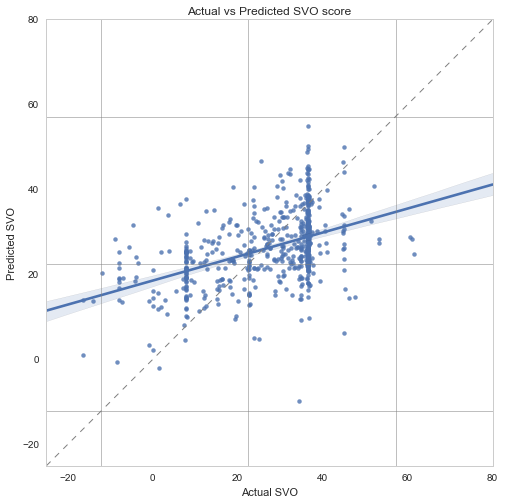

In [133]:
reg_pred_actual(y_svo, y_fit1_pred)

In [248]:
fit1_labels = pd.Series(y_fit1_pred).apply(angle2cat)

In [249]:
accuracy_score(y_type, fit1_labels)

0.76013513513513509

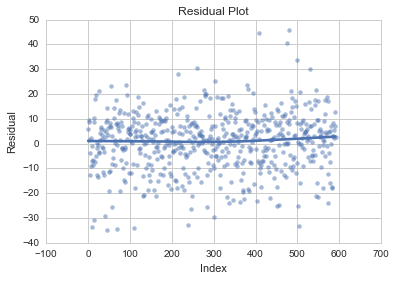

In [250]:
x = list(range(0, len(y_fit1_pred)))
index_residual_plot(x, fit1_residuals, fit_reg=True)


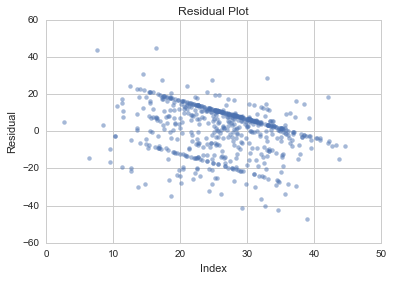

In [1125]:
index_residual_plot(y_fit1_pred, fit1_residuals)

In [1129]:
# ax = plt.axes()
# sm.graphics.influence_plot(fit1_res, ax=ax, criterion="cooks", figsize=(8,6))

### Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [252]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)

In [115]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 15],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False]}

In [116]:
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg_grid = GridSearchCV(rf_reg, param_grid=param_grid)

In [135]:
rf_reg_grid.fit(X, y_svo)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'min_samples_split': [1, 3, 10], 'max_features': [1, 3, 15], 'bootstrap': [True, False], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [140]:
rf_reg_grid.best_score_

0.024798734072853806

In [253]:
estimator.fit(X, y_svo)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [254]:
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -97.14


In [255]:
y_pred = estimator.predict(X)

In [256]:
r2_score(y_svo, y_pred)

0.9231726553374171

In [257]:
mean_squared_error(y_svo, y_pred)

13.973677949928327

In [258]:
rf_labels = pd.Series(y_pred).apply(angle2cat)

In [259]:
# rf_labels

In [260]:
accuracy_score(y_type, rf_labels)

0.94932432432432434

In [262]:
yt = y_pred + (.085 * (y_pred - y_pred.mean()))**3

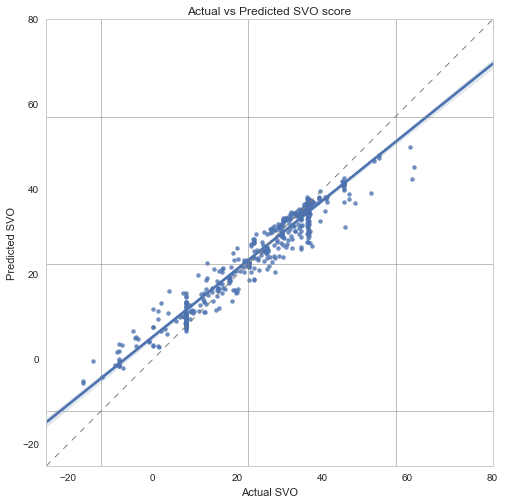

In [263]:
reg_pred_actual(y_svo, y_pred)

In [264]:
estimator.feature_importances_

array([  5.79516582e-03,   2.09166868e-03,   4.99333195e-03,
         4.41856951e-03,   2.82116691e-03,   5.72733747e-03,
         5.72545043e-03,   7.91929499e-04,   2.90381354e-02,
         2.06399259e-02,   5.32365884e-03,   4.86096812e-04,
         1.35730693e-02,   1.45950138e-02,   1.76066381e-02,
         2.12925717e-02,   1.17857323e-02,   1.15018157e-02,
         1.31311321e-02,   8.19379719e-02,   7.95623558e-02,
         1.11765865e-01,   4.29244872e-02,   4.73258114e-02,
         3.64501282e-01,   6.49331279e-02,   6.33189840e-03,
         3.14525718e-03,   6.11041394e-03,   1.23119902e-04])

In [265]:
rf_residuals = y_svo - yt

In [98]:
def index_residual_plot(index, residual, fit_reg=False):
    df = pd.DataFrame({'Index': index, 'Residual': residual})
    sns.regplot(x='Index', y='Residual', 
                data=df, lowess=True, fit_reg=fit_reg,
                scatter_kws={'alpha':0.5})
    plt.title("Residual Plot")

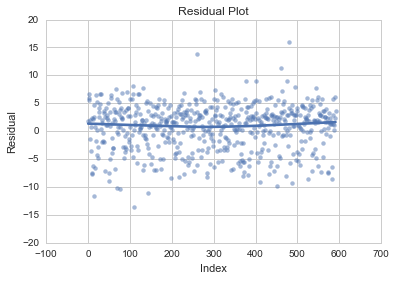

In [1142]:
index_residual_plot(x, rf_residuals, fit_reg=True)

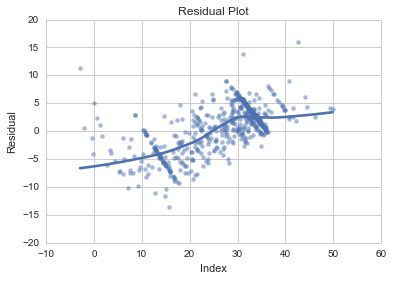

In [1143]:
index_residual_plot(y_pred, rf_residuals, fit_reg=True)

In [1144]:
imp = pd.Series(estimator.feature_importances_)

### Gradient Boosting Regressor

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

In [173]:
gb_reg = GradientBoostingRegressor(n_estimators=100)

In [174]:
gb_reg.fit(X, y_svo)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [175]:
y_gb_pred = gb_reg.predict(X)

In [176]:
r2_score(y_svo, y_gb_pred)

0.4530684977840499

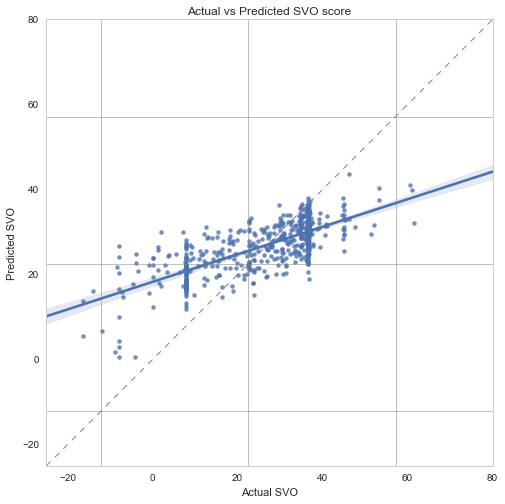

In [177]:
reg_pred_actual(y_svo, y_gb_pred)

In [178]:
gb_residuals = y_svo - y_gb_pred

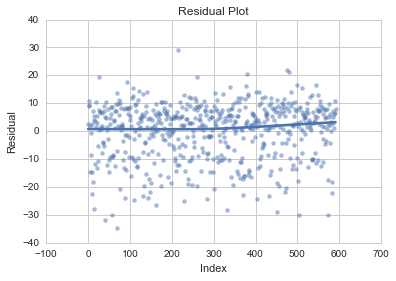

In [179]:
index_residual_plot(x, gb_residuals, fit_reg=True)

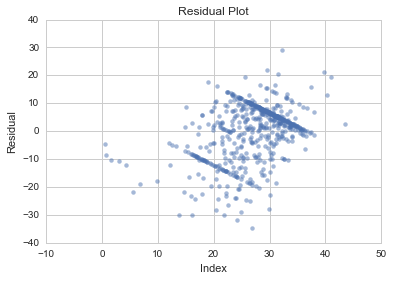

In [1153]:
index_residual_plot(y_gb_pred, gb_residuals)

### Support Vector Regressor

In [1154]:
from sklearn.svm import SVR

In [1155]:
svr_reg = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1156]:
svr_reg.fit(X, y_svo)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1157]:
y_svr_pred = svr_reg.predict(X)

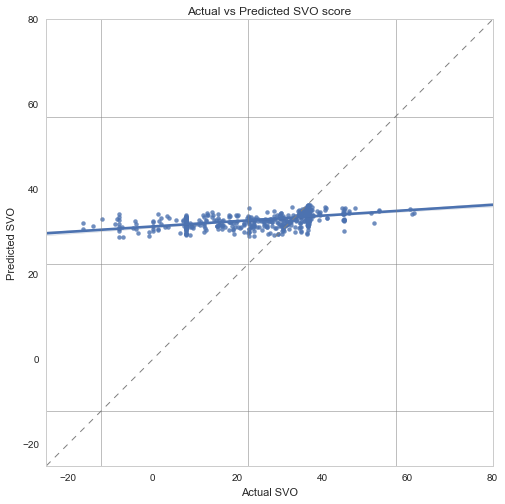

In [1158]:
reg_pred_actual(y_svo, y_svr_pred)

In [1159]:
svr_residuals = y_svo - y_svr_pred

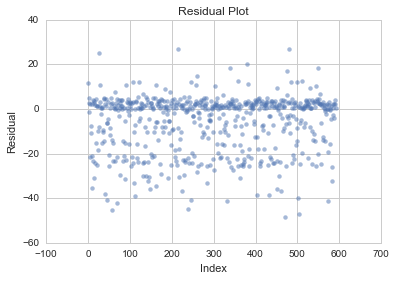

In [1160]:
index_residual_plot(x, svr_residuals)

In [1161]:
svo.type.unique()

array(['prosocial', 'individualistic', 'altruistic', 'competitive'], dtype=object)

In [1162]:
pd.factorize(tdf.type.as_matrix())[1]

array(['prosocial', 'individualistic', 'altruistic', 'competitive'], dtype=object)

In [296]:
def angle2cat(SVO_angles):
    if SVO_angles >= 57.15:
        return 2 #"altruistic"
    elif SVO_angles < 57.15 and SVO_angles >= 22.45:
        return 0 #"prosocial"
    elif SVO_angles < 22.45 and SVO_angles >= -12.04:
        return 1 #"individualistic"
    elif SVO_angles < -12.04:
        return 3 #"competitive"

In [91]:
labels = pd.Series(y_pred).apply(angle2cat)
accuracy_score(y_type, labels)

### KNN Regressor

In [266]:
from sklearn.neighbors import KNeighborsRegressor

In [267]:
knn_reg = KNeighborsRegressor()

In [268]:
knn_reg.fit(X, y_svo)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [269]:
y_knn_pred = knn_reg.predict(X)

In [270]:
r2_score(y_svo, y_knn_pred)

0.53186431187796779

In [271]:
labels = pd.Series(y_knn_pred).apply(angle2cat)
accuracy_score(y_type, labels)

0.83614864864864868

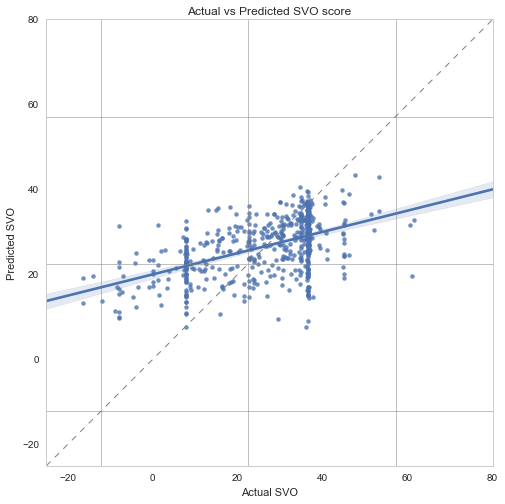

In [181]:
reg_pred_actual(y_svo, y_knn_pred)

# Classification

### Ensemble Classifiers

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [37]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 15],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [38]:
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                             n_estimators=300)

In [63]:
rf_grid = GridSearchCV(rf_clf, param_grid=param_grid)

In [144]:
gb_grid = GridSearchCV(rf_clf, param_grid=param_grid)

In [145]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50, 150, 300]
             }

In [146]:
ab_grid = GridSearchCV(ab_clf, param_grid=param_grid)

In [147]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 15], 'bootstrap': [True, False], 'min_samples_split': [1, 3, 10], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [150]:
rf_grid.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [151]:
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 15], 'bootstrap': [True, False], 'min_samples_split': [1, 3, 10], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [153]:
# gb_grid.best_params_

In [ ]:
ab_grid.fit(X_train, y_train)

In [ ]:
ab_grid.best_estimator_

In [49]:
score = cross_val_score(rf_clf, X, y_type, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.83


In [39]:
rf_clf.fit(X_train_res, y_train_res)
gb_clf.fit(X_train_res, y_train_res)
ab_clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=300, random_state=None)

In [40]:
y_pred = rf_clf.predict(X_test)

In [41]:
from sklearn.metrics import classification_report

In [44]:
cr = classification_report(y_test, y_pred, target_names=["prosocial", "proself"])

In [48]:
print(cr)

             precision    recall  f1-score   support

  prosocial       0.73      0.77      0.75        43
    proself       0.90      0.89      0.90       106

avg / total       0.85      0.85      0.85       149



In [70]:
# accuracy_score(y_test, y_pred)

In [56]:
imp = pd.Series(rf_clf.feature_importances_)

In [59]:
# feats = pd.DataFrame({'col': target_cols, 'imps': imp})

In [55]:
feats.sort_values('imps', ascending=False).plot(
    kind='bar', x=feats.sort_values('imps', ascending=False).col, figsize=(18,4))

NameError: name 'feats' is not defined

### Support Vector Machine

In [115]:
from sklearn.svm import SVC

In [162]:
svc_clf = SVC(C=10, kernel='linear', probability=True)

In [62]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [63]:
clf = GridSearchCV(estimator, param_grid)

In [163]:
svc_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [87]:
y_pred2 = estimator2.predict(X_test)

In [132]:
# clf.best_params_

In [178]:
# clf.best_estimator_

In [179]:
# clf.best_score_

In [177]:
# score = cross_val_score(clf.best_estimator_, X, y_type, cv=10).mean()
# print("Score with the entire dataset = %.2f" % score)

### KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
knn_clf = KNeighborsClassifier()

In [51]:
param_grid = [{
    'weights': ['uniform', 'distance'], 
    'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'metric': ['euclidean', 'cityblock']
}]

In [52]:
knn_grid = GridSearchCV(knn_clf, param_grid)

In [53]:
knn_grid.fit(X, y_ps)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'metric': ['euclidean', 'cityblock'], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [70]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [71]:
score = cross_val_score(knn_grid.best_estimator_, X, y_type, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.82


In [72]:
y_knn_pred = knn_grid.best_estimator_.predict(X_test)

In [73]:
accuracy_score(y_test, y_knn_pred)

1.0

### Voting Classifier

In [546]:
from sklearn.ensemble import VotingClassifier

In [555]:
vote_clf = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_), 
        ('gb', gb_grid.best_estimator_), 
        ('knn', knn_grid.best_estimator_)
    ], voting='soft', weights=[2, 5, 1])

In [556]:
score = cross_val_score(vote_clf, X, y_type, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.82


### Autolearning Classifier

In [470]:
# import autosklearn.classification

### Diagnostics and Model Checking

In [59]:
## See how the model performs with more data

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [61]:
# classification_report(y_test, y_pred, target_names=f[1])

In [ ]:
# confusion_matrix(y_test, y_pred)

In [122]:
adf = pd.DataFrame({'train': y_test, 'test': y_pred})

In [125]:
adf['loss'] = adf.apply(lambda r: 1 if r['test'] == r['train'] else 0, axis=1)

In [138]:
f = pd.factorize(tdf.type.as_matrix())

In [150]:
# adf.replace({
#     0: 'individualistic',
#     1: 'prosocial',
#     2: 'altruistic',
#     3: 'competitive'
# })

### Learning Curve

In [111]:
scores = []
sizes = range(100, 700, 100)
for size in sizes:
    sample = svo.sample(size)
    df = sample.loc[:, ['type'] + target_cols]
    y = pd.factorize(df.type)[0]
    X = df.ix[:, 1:].as_matrix()
    score = cross_val_score(gb_grid.best_estimator_, X, y, cv=3).mean()
    scores.append(score)

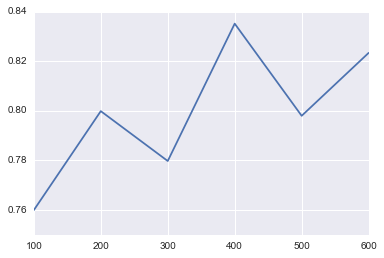

In [112]:
plt.plot(sizes, scores)
#list(sizes)

### ROC curve

In [142]:
from sklearn.metrics import roc_curve, auc

In [169]:
X.shape

(640, 27)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)

In [177]:
probs = gb_clf.predict_proba(X_test)
preds = probs[:,1]

In [178]:
probs2 = svc_clf.predict_proba(X_test)
preds2 = probs2[:,1]

In [179]:
probs3 = knn_clf.predict_proba(X_test)
preds3 = probs3[:,1]

In [180]:
probs4 = rf_clf.predict_proba(X_test)
preds4 = probs4[:,1]

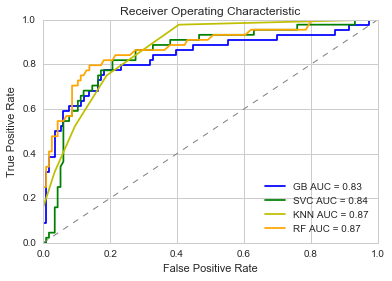

In [194]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, threshold = roc_curve(y_test, preds2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, threshold = roc_curve(y_test, preds3)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, threshold = roc_curve(y_test, preds4)
roc_auc4 = auc(fpr4, tpr4)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'GB AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'SVC AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'y', label = 'KNN AUC = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'orange', label = 'RF AUC = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='gray', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig("../img/roc.png")

In [551]:
probs = pd.Series(preds).apply(np.max)

In [188]:
adf['prob'] = probs

In [196]:
# adf[adf.loss==0]

In [295]:
svo.type.value_counts() / svo.type.count()

prosocial          0.698142
individualistic    0.292570
competitive        0.004644
altruistic         0.004644
Name: type, dtype: float64

### Identifying misclassified points

In [621]:
# Classifiers
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
svc_clf = SVC(C=10, kernel='linear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [622]:
clf = knn_clf

In [623]:
min_count = 0
runs = []
rdf = None
## train a classifier on anew training and testing set
while min_count <= 30:
    # Create placeholder vector
    run = np.full((1,X.shape[0],), np.nan)
    X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)
    # tet on the entire data set
    clf.fit(X_train, y_train)
    ## make predictions with the classifier
    y_pred = clf.predict(X_test)
    ## check if they're correct or incorrect
    misclassified = ~np.equal(y_pred, y_test)
#     print(pd.Series(misclassified).value_counts())
    # for each data point in the test set, if it's misclassified set the it's it's datapoint 
    # misclassified
    for dix, vix in enumerate(X_test.index):
        run[0][vix] = 1 if misclassified[dix] else 0
    runs.append(run[0])
    rdf = pd.DataFrame(runs)
    min_count = np.min(rdf.count())

IndexError: index 628 is out of bounds for axis 0 with size 592

In [135]:
hard_cases = rdf.mean()[rdf.mean() > .75].index
easy_cases = rdf.mean()[rdf.mean() == 0].index

In [136]:
svo.loc[hard_cases, 'case'] = 'hard'
svo.loc[easy_cases, 'case'] = 'easy'

In [83]:
# Style settings
sns.set_style('whitegrid')

def remove_gridlines(ax):
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    
def modify_gridlines(ax):
    for line in ax.get_ygridlines():
        line.set_linestyle(':')

    for line in ax.get_xgridlines():
        line.set_linestyle(':')

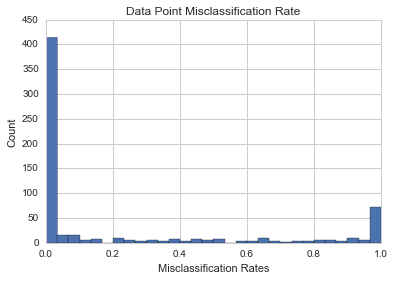

In [164]:
# Distribution of incorrect classifications
rdf.mean().hist(bins=30)
plt.title("Data Point Misclassification Rate")
plt.xlabel("Misclassification Rates")
plt.ylabel("Count")
plt.savefig("../img/misclassification_rate.png")

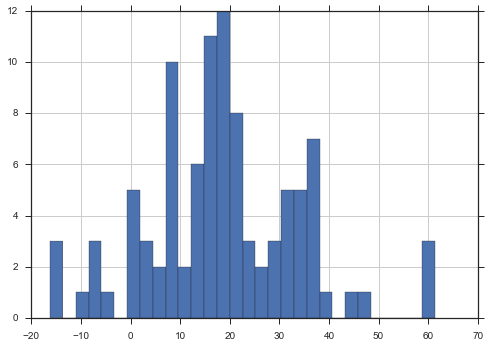

In [685]:
hard = svo.ix[hard_cases].svo.hist(bins=30)

In [587]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [588]:
cdf = svo.loc[:, ['case'] + target_cols]

In [589]:
X_clust = cdf.ix[cdf.case.notnull(), 1:]

In [590]:
X_clust_scaled = min_max_scaler.fit_transform(X_clust)

In [591]:
mds = MDS(2, max_iter=100, n_init=1)
tsne = TSNE(n_components=2, perplexity=50)
pca = PCA(n_components=2)

In [592]:
clust = tsne
X_mds = clust.fit_transform(X_clust_scaled)

In [593]:
mdf = pd.DataFrame({
    'x': X_mds.transpose()[0], 
    'y': X_mds.transpose()[1], 
    'case': cdf[cdf.case.notnull()].case
})

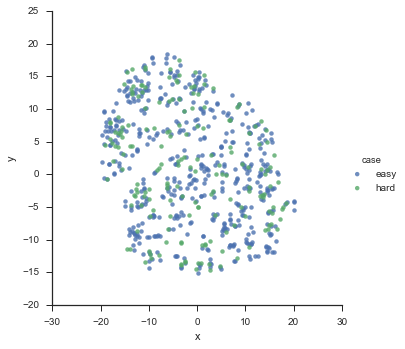

In [594]:
plt.figure(figsize=(12, 12))
sns.lmplot(x='x', y='y', hue='case',
           fit_reg=False, data=mdf, scatter_kws={'alpha':0.8})

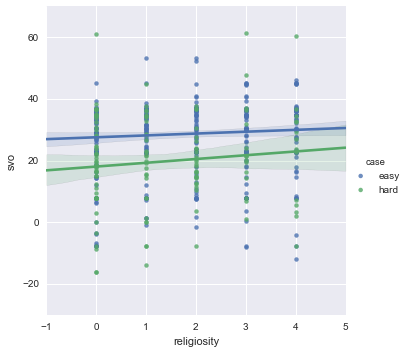

In [323]:
sns.lmplot(x='religiosity', y='svo', data=svo[svo.age < 100], hue='case')

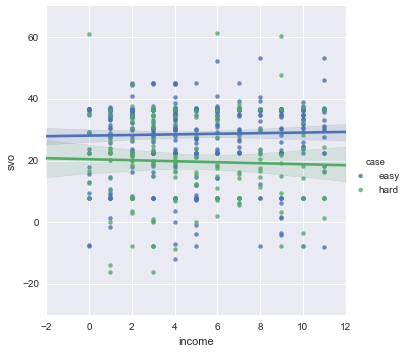

In [321]:
sns.lmplot(x='income', y='svo', data=svo[svo.age < 100], hue='case')

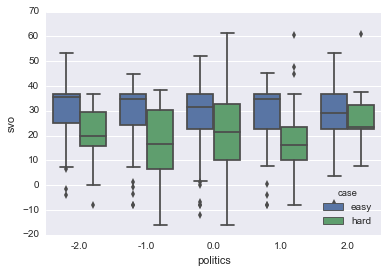

In [330]:
sns.boxplot(x='politics', y='svo', data=svo[svo.age < 100], hue='case')

In [636]:
### Check if the hard cases are in the bad values
hdf = svo.loc[svo.case=='hard', :]

AttributeError: 'DataFrame' object has no attribute 'case'

### Classifying Hard Cases

In [578]:
gb_hard_clf = GradientBoostingClassifier(n_estimators=300)
rf_hard_clf = RandomForestClassifier(n_estimators=300)
svc_hard_clf = SVC(C=1, kernel='linear', probability=False)
knn_hard_clf = knn_clf = KNeighborsClassifier(n_neighbors=10)

In [565]:
y_case = pd.factorize(svo.type)[0]

In [570]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(svo[target_cols], y_type, test_size=.25)

In [571]:
svc_hard_clf.fit(X_train_c, y_train_c)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [573]:
score = cross_val_score(svc_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.72


In [575]:
score = cross_val_score(gb_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.76


In [577]:
score = cross_val_score(rf_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.77


In [579]:
score = cross_val_score(knn_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.74


In [455]:
# case_pred = svc_hard_clf.predict(X_test_c)

In [ ]:
# confusion_matrix(case_pred, y_test_c)

In [ ]:
# score = cross_val_score(gb_hard_clf, svo[target_cols], y_case, cv=3).mean()
# print("Score with the entire dataset = %.2f" % score)

In [ ]:
# np.argmax(gb_hard_clf.feature_importances_)

target_cols[16]

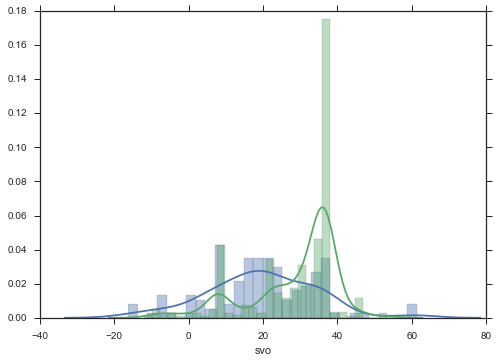

In [411]:
# sns.set(style="ticks", color_codes=True)
# g = sns.FacetGrid(svo[svo.notnull()], col="case")
# g = g.map(plt.hist, "svo", bins=30)
sns.distplot(svo[svo.case=='hard'].svo, bins=30)
sns.distplot(svo[svo.case=='easy'].svo, bins=30)

In [344]:
# sns.lmplot(x='ev4', y='svo', data=svo, hue='case')

In [302]:
# X = cluster_df.ix[:, 1:].as_matrix()
# X_scaled = min_max_scaler.fit_transform(X)

In [174]:
# np.in1d(y_pred, y_test)

In [564]:
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
svc_clf = SVC(C=10, kernel='linear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

### Reviewing classification probabilities